In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import joblib
import os
from datetime import datetime

In [7]:
def analyze_dataset(X, X_scaled, categorical_columns, numeric_cols, df, y):
    """Analyze and visualize dataset characteristics"""
    print("=" * 50)
    print("DATASET ANALYSIS")
    print("=" * 50)

    # Basic dataset information
    print(f"\nTotal samples: {X.shape[0]}")
    print(f"Total features: {X.shape[1]}")
    print(f"Numeric features: {len(numeric_cols)}")
    print(f"Categorical features: {len(categorical_columns)}")
    print(f"Total classes: {len(np.unique(y))}")

    # Class distribution
    class_dist = pd.Series(y).value_counts()
    print("\nClass Distribution:")
    for idx, count in class_dist.items():
        print(f"Class {idx}: {count} samples ({count/len(y)*100:.2f}%)")

    # Visualizations
    plt.figure(figsize=(15, 10))

    # Plot 1: Class Distribution
    plt.subplot(2, 2, 1)
    sns.countplot(data=pd.DataFrame({'y': y}), x='y')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Plot 2: Feature Correlation Heatmap (for numeric features)
    plt.subplot(2, 2, 2)
    correlation = df[numeric_cols].corr()
    sns.heatmap(correlation, cmap='coolwarm', center=0, annot=False)
    plt.title('Feature Correlation Heatmap')

    # Plot 3: Feature Scaling Comparison
    plt.subplot(2, 2, 3)
    sample_features = np.random.choice(numeric_cols, 5)
    box_data = pd.DataFrame({
        'Before Scaling': X[:, :len(numeric_cols)].flatten(),
        'After Scaling': X_scaled[:, :len(numeric_cols)].flatten()
    })
    sns.boxplot(data=box_data)
    plt.title('Feature Scaling Comparison')

    # Plot 4: Feature Importance (using variance)
    plt.subplot(2, 2, 4)
    feature_variance = np.var(X_scaled, axis=0)
    top_features = np.argsort(feature_variance)[-10:]
    plt.barh(range(10), feature_variance[top_features])
    plt.title('Top 10 Features by Variance')

    plt.tight_layout()
    plt.show()

In [8]:
def display_models_summary(models_dict):
    """
    Display detailed summary of model parameters and configurations

    Parameters:
    -----------
    models_dict : dict
        Dictionary containing model name and model object pairs
    """
    print("=" * 50)
    print("MODEL PARAMETERS SUMMARY")
    print("=" * 50)

    for model_name, model in models_dict.items():
        print(f"\n{model_name} Configuration:")
        print("-" * 30)

        # Get all parameters of the model
        params = model.get_params()

        # Group parameters by type for better organization
        numeric_params = {k: v for k, v in params.items() if isinstance(v, (int, float))}
        categorical_params = {k: v for k, v in params.items() if isinstance(v, str)}
        other_params = {k: v for k, v in params.items()
                       if not isinstance(v, (int, float, str)) and v is not None}

        # Display numeric parameters
        if numeric_params:
            print("\nNumeric Parameters:")
            for param, value in sorted(numeric_params.items()):
                print(f"  {param}: {value}")

        # Display categorical parameters
        if categorical_params:
            print("\nCategorical Parameters:")
            for param, value in sorted(categorical_params.items()):
                print(f"  {param}: {value}")

        # Display other parameters
        if other_params:
            print("\nOther Parameters:")
            for param, value in sorted(other_params.items()):
                print(f"  {param}: {str(value)}")

        # Additional model-specific information
        if model_name == 'Neural Network':
            if hasattr(model, 'n_layers_'):
                print(f"\nNetwork Architecture:")
                print(f"  Number of layers: {model.n_layers_}")
                print(f"  Layer sizes: {model.hidden_layer_sizes}")
        elif model_name == 'SVM':
            print(f"\nKernel Information:")
            print(f"  Kernel type: {model.kernel}")
            if model.kernel == 'rbf':
                print(f"  Gamma: {model.gamma}")
        elif model_name == 'Naive Bayes':
            if hasattr(model, 'class_prior_'):
                print("\nClass Prior Probabilities:")
                for i, prior in enumerate(model.class_prior_):
                    print(f"  Class {i}: {prior:.4f}")

    print("\n" + "=" * 50)

In [9]:
def save_models(svm_model, nb_model, ann_model, scaler, le, enc, base_dir='models'):
    """
    Save all models and preprocessors with timestamp

    Parameters:
    -----------
    svm_model : sklearn.svm.SVC
        Trained SVM model
    nb_model : sklearn.naive_bayes.GaussianNB
        Trained Naive Bayes model
    ann_model : sklearn.neural_network.MLPClassifier
        Trained Neural Network model
    scaler : sklearn.preprocessing.StandardScaler
        Fitted scaler for feature scaling
    le : sklearn.preprocessing.LabelEncoder
        Fitted label encoder for target variable
    enc : sklearn.preprocessing.OneHotEncoder
        Fitted one-hot encoder for categorical variables
    base_dir : str, default='models'
        Base directory to save models

    Returns:
    --------
    str
        Path to the directory where models are saved
    """
    try:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        # Create base directory if it doesn't exist
        if not os.path.exists(base_dir):
            os.makedirs(base_dir)

        # Create timestamped directory for this save
        model_dir = os.path.join(base_dir, f'models_{timestamp}')
        os.makedirs(model_dir)

        # Save models
        print("Saving models...")
        joblib.dump(svm_model, os.path.join(model_dir, 'svm_model.joblib'))
        joblib.dump(nb_model, os.path.join(model_dir, 'nb_model.joblib'))
        joblib.dump(ann_model, os.path.join(model_dir, 'ann_model.joblib'))

        # Save preprocessors
        print("Saving preprocessors...")
        joblib.dump(scaler, os.path.join(model_dir, 'scaler.joblib'))
        joblib.dump(le, os.path.join(model_dir, 'label_encoder.joblib'))
        joblib.dump(enc, os.path.join(model_dir, 'onehot_encoder.joblib'))

        # Save model information
        print("Saving model information...")
        with open(os.path.join(model_dir, 'model_info.txt'), 'w') as f:
            f.write(f"Models saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("\nModel Structures:\n")
            f.write(f"SVM parameters: {str(svm_model.get_params())}\n")
            f.write(f"Naive Bayes parameters: {str(nb_model.get_params())}\n")
            f.write(f"Neural Network parameters: {str(ann_model.get_params())}\n")

            # Add performance metrics if available
            if hasattr(svm_model, 'best_score_'):
                f.write(f"\nSVM best score: {svm_model.best_score_}\n")
            if hasattr(ann_model, 'best_validation_score_'):
                f.write(f"Neural Network best validation score: {ann_model.best_validation_score_}\n")

        print(f"Models and preprocessors saved in: {model_dir}")
        return model_dir

    except Exception as e:
        print(f"Error saving models: {str(e)}")
        raise

def load_models(model_dir):
    """
    Load all models and preprocessors from saved directory

    Parameters:
    -----------
    model_dir : str
        Directory containing saved models and preprocessors

    Returns:
    --------
    dict
        Dictionary containing loaded models and preprocessors

    Raises:
    -------
    FileNotFoundError
        If model directory or required files not found
    Exception
        For other loading errors
    """
    try:
        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Model directory not found: {model_dir}")

        required_files = [
            'svm_model.joblib', 'nb_model.joblib', 'ann_model.joblib',
            'scaler.joblib', 'label_encoder.joblib', 'onehot_encoder.joblib'
        ]

        # Check if all required files exist
        missing_files = [f for f in required_files
                        if not os.path.exists(os.path.join(model_dir, f))]
        if missing_files:
            raise FileNotFoundError(f"Missing required files: {missing_files}")

        print("Loading models and preprocessors...")
        # Load models
        svm_model = joblib.load(os.path.join(model_dir, 'svm_model.joblib'))
        nb_model = joblib.load(os.path.join(model_dir, 'nb_model.joblib'))
        ann_model = joblib.load(os.path.join(model_dir, 'ann_model.joblib'))

        # Load preprocessors
        scaler = joblib.load(os.path.join(model_dir, 'scaler.joblib'))
        le = joblib.load(os.path.join(model_dir, 'label_encoder.joblib'))
        enc = joblib.load(os.path.join(model_dir, 'onehot_encoder.joblib'))

        # Return everything in a dictionary
        return {
            'svm_model': svm_model,
            'nb_model': nb_model,
            'ann_model': ann_model,
            'scaler': scaler,
            'label_encoder': le,
            'onehot_encoder': enc
        }

    except FileNotFoundError as e:
        print(f"File not found error: {str(e)}")
        return None
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return None

In [10]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """Enhanced model evaluation with detailed visualizations"""
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    print(f"\nEvaluating {model_name}")
    print("=" * 50)
    print(f"\nCross-validation scores:")
    print(f"Mean: {cv_mean:.3f} (+/- {cv_std * 2:.3f})")

    # Create subplot figure
    plt.figure(figsize=(20, 10))

    # 1. Confusion Matrix with improved visualization
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['normal', 'DoS', 'R2L', 'Probe', 'U2R'],
                yticklabels=['normal', 'DoS', 'R2L', 'Probe', 'U2R'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # 2. ROC Curves
    plt.subplot(1, 2, 2)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_test_pred_bin = label_binarize(y_test_pred, classes=np.unique(y_test))

    n_classes = y_test_bin.shape[1]
    class_names = ['normal', 'DoS', 'R2L', 'Probe', 'U2R']

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_test, y_test_pred,
                              target_names=['normal', 'DoS', 'R2L', 'Probe', 'U2R']))

    return cv_mean, cv_std


Loading datasets...
Training set shape: (125973, 42)
Test set shape: (22544, 42)

Mapping attack types to categories...
Preprocessing data...
 'xlock' 'xsnoop']

Encoding categorical features...
Processing numeric features...
Feature matrix shape - Training: (125973, 122), Test: (22544, 122)

Processing labels...
Unique classes found: ['DoS' 'Probe' 'R2L' 'U2R' 'normal']

Cleaning test data...
Final test set shape: (22544, 122)

Scaling features...

Splitting training data...
Training set size: 100778
Validation set size: 25195

Initializing models...
SVM model initialized
Naive Bayes model initialized
Neural Network model initialized

Analyzing dataset...
DATASET ANALYSIS

Total samples: 125973
Total features: 122
Numeric features: 38
Categorical features: 3
Total classes: 5

Class Distribution:
Class 4: 67343 samples (53.46%)
Class 0: 45927 samples (36.46%)
Class 1: 11656 samples (9.25%)
Class 2: 995 samples (0.79%)
Class 3: 52 samples (0.04%)


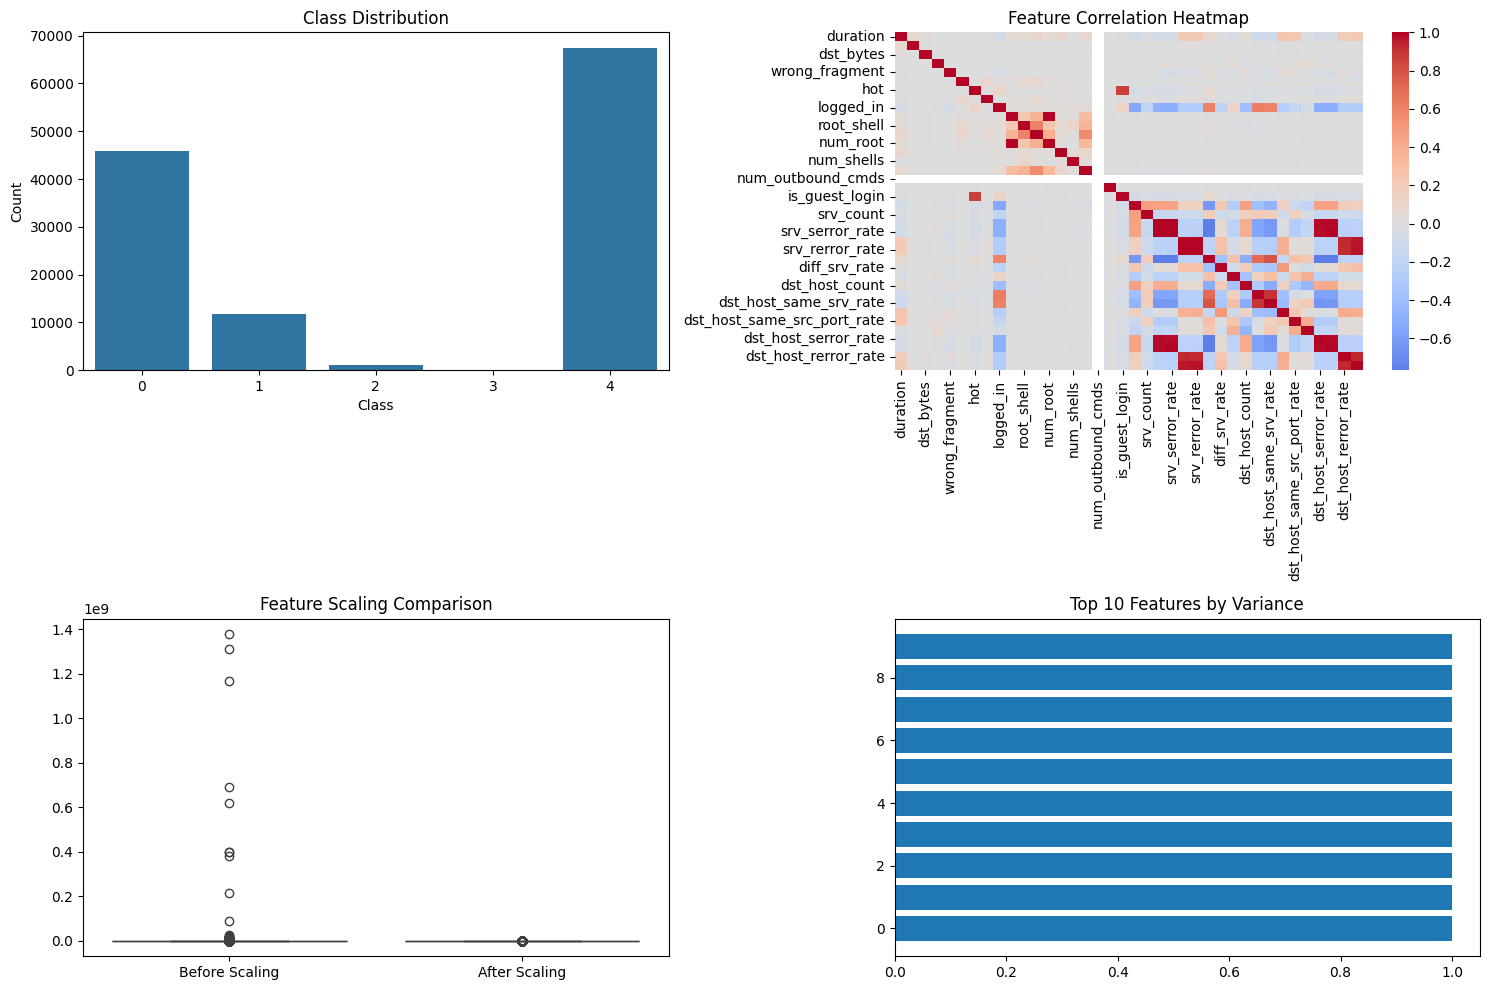


Displaying model parameters...
MODEL PARAMETERS SUMMARY

SVM Configuration:
------------------------------

Numeric Parameters:
  C: 1
  break_ties: False
  cache_size: 200
  coef0: 0.0
  degree: 3
  max_iter: -1
  probability: True
  random_state: 42
  shrinking: True
  tol: 0.001
  verbose: False

Categorical Parameters:
  decision_function_shape: ovr
  gamma: scale
  kernel: rbf

Kernel Information:
  Kernel type: rbf
  Gamma: scale

Naive Bayes Configuration:
------------------------------

Numeric Parameters:
  var_smoothing: 1e-09

Neural Network Configuration:
------------------------------

Numeric Parameters:
  alpha: 0.0001
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: True
  epsilon: 1e-08
  learning_rate_init: 0.001
  max_fun: 15000
  max_iter: 1000
  momentum: 0.9
  n_iter_no_change: 10
  nesterovs_momentum: True
  power_t: 0.5
  random_state: 42
  shuffle: True
  tol: 0.0001
  validation_fraction: 0.1
  verbose: False
  warm_start: False

Categorical Parameters:
  acti

In [ ]:
# Main execution
if __name__ == "__main__":
    try:
        # Load data
        print("Loading datasets...")
        col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

        # Ensure file paths are correct and files exist
        train_path = 'NSL_KDD_Train.csv'
        test_path = 'NSL_KDD_Test.csv'

        if not os.path.exists(train_path) or not os.path.exists(test_path):
            raise FileNotFoundError("Training or test dataset not found. Please check file paths.")

        df = pd.read_csv(train_path, header=None, names=col_names)
        df_test = pd.read_csv(test_path, header=None, names=col_names)

        print(f"Training set shape: {df.shape}")
        print(f"Test set shape: {df_test.shape}")

        # Validate data
        if df.isnull().values.any():
            print("Warning: Training set contains missing values")
        if df_test.isnull().values.any():
            print("Warning: Test set contains missing values")

        # Map attacks to categories
        print("\nMapping attack types to categories...")
        attack_dict = {
            'normal': 'normal',
            'neptune': 'DoS', 'back': 'DoS', 'land': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
            'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
            'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
            'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L',
            'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
            'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'
        }

        # Preprocess data with error checking
        print("Preprocessing data...")
        df['label'] = df['label'].str.rstrip('.')
        df['attack_category'] = df['label'].map(attack_dict)
        df_test['attack_category'] = df_test['label'].map(attack_dict)

        # Check for unmapped categories
        unmapped_train = df['label'][~df['label'].isin(attack_dict.keys())].unique()
        unmapped_test = df_test['label'][~df_test['label'].isin(attack_dict.keys())].unique()

        if len(unmapped_train) > 0:
            print(f"Warning: Found unmapped attack types in training set: {unmapped_train}")
        if len(unmapped_test) > 0:
            print(f"Warning: Found unmapped attack types in test set: {unmapped_test}")

        # Handle categorical features
        print("\nEncoding categorical features...")
        categorical_columns = ['protocol_type', 'service', 'flag']

        # Validate categorical columns exist
        missing_cols = [col for col in categorical_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing categorical columns: {missing_cols}")

        enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        cat_enc = enc.fit_transform(df[categorical_columns])
        cat_enc_test = enc.transform(df_test[categorical_columns])

        # Get feature names
        cat_cols = []
        for i, col in enumerate(categorical_columns):
            cat_cols.extend([f"{col}_{val}" for val in enc.categories_[i]])

        # Prepare numeric features
        print("Processing numeric features...")
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        numeric_cols = [col for col in numeric_cols if col not in ['label']]

        # Validate numeric columns
        if not numeric_cols:
            raise ValueError("No numeric columns found in dataset")

        # Combine features
        X = np.hstack((df[numeric_cols].values, cat_enc))
        X_test = np.hstack((df_test[numeric_cols].values, cat_enc_test))

        print(f"Feature matrix shape - Training: {X.shape}, Test: {X_test.shape}")

        # Handle labels
        print("\nProcessing labels...")
        all_categories = set(df['attack_category'].unique()) | set(df_test['attack_category'].unique())
        all_categories = all_categories - {np.nan}  # Remove nan if present

        # Fill NaN values
        most_common_category = df['attack_category'].mode()[0]
        df['attack_category'] = df['attack_category'].fillna(most_common_category)
        df_test['attack_category'] = df_test['attack_category'].fillna(most_common_category)

        # Label encoding
        le = LabelEncoder()
        le.fit(list(all_categories))
        y = le.transform(df['attack_category'])
        y_test = le.transform(df_test['attack_category'])

        print(f"Unique classes found: {le.classes_}")

        # Clean test data
        print("\nCleaning test data...")
        mask = df_test['attack_category'] != 'unknown'
        df_test = df_test[mask]
        X_test = X_test[mask]
        y_test = y_test[mask]

        mask_isna = ~df_test['attack_category'].isna()
        df_test = df_test[mask_isna]
        X_test = X_test[mask_isna]
        y_test = y_test[mask_isna]

        print(f"Final test set shape: {X_test.shape}")

        # Scale features
        print("\nScaling features...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_test_scaled = scaler.transform(X_test)

        # Split training data
        print("\nSplitting training data...")
        X_train, X_val, y_train, y_val = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"Training set size: {X_train.shape[0]}")
        print(f"Validation set size: {X_val.shape[0]}")

        # Initialize models with try-except for each
        print("\nInitializing models...")
        try:
            svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
            print("SVM model initialized")
        except Exception as e:
            print(f"Error initializing SVM model: {str(e)}")
            svm_model = None

        try:
            nb_model = GaussianNB()
            print("Naive Bayes model initialized")
        except Exception as e:
            print(f"Error initializing Naive Bayes model: {str(e)}")
            nb_model = None

        try:
            ann_model = MLPClassifier(
                hidden_layer_sizes=(512, 256, 128, 64, 32, 16),
                max_iter=1000,
                activation='relu',
                solver='adam',
                random_state=42,
                learning_rate='adaptive',
                early_stopping=True,
                validation_fraction=0.1
            )
            print("Neural Network model initialized")
        except Exception as e:
            print(f"Error initializing Neural Network model: {str(e)}")
            ann_model = None

        # Create models dictionary with only successfully initialized models
        models_dict = {}
        if svm_model is not None:
            models_dict['SVM'] = svm_model
        if nb_model is not None:
            models_dict['Naive Bayes'] = nb_model
        if ann_model is not None:
            models_dict['Neural Network'] = ann_model

        if not models_dict:
            raise ValueError("No models were successfully initialized")

        # Analyze dataset
        print("\nAnalyzing dataset...")
        analyze_dataset(X, X_scaled, categorical_columns, numeric_cols, df, y)

        # Display model parameters
        print("\nDisplaying model parameters...")
        display_models_summary(models_dict)

        # Train and evaluate models
        print("\nTraining and evaluating models...")
        results = {}
        for model_name, model in models_dict.items():
            try:
                print(f"\nEvaluating {model_name}...")
                cv_mean, cv_std = evaluate_model(
                    model, X_train, X_val, X_test_scaled,
                    y_train, y_val, y_test, model_name
                )
                results[model_name] = {'mean': cv_mean, 'std': cv_std}
            except Exception as e:
                print(f"Error evaluating {model_name}: {str(e)}")

        if not results:
            raise ValueError("No models were successfully evaluated")

        # Compare models
        models_comparison = pd.DataFrame({
            'Model': list(results.keys()),
            'CV Mean Accuracy': [res['mean'] for res in results.values()],
            'CV Std': [res['std'] for res in results.values()]
        })

        print("\nModel Comparison:")
        print(models_comparison)

        # Save models
        print("\nSaving models...")
        try:
            model_dir = save_models(
                svm_model=svm_model,
                nb_model=nb_model,
                ann_model=ann_model,
                scaler=scaler,
                le=le,
                enc=enc
            )
            print(f"Models saved successfully in {model_dir}")
        except Exception as e:
            print(f"Error saving models: {str(e)}")
            model_dir = None

        # Test loaded models
        if model_dir is not None:
            print("\nTesting loaded models...")
            loaded_models = load_models(model_dir)
            if loaded_models is not None:
                print("Models loaded successfully!")

                # Test predictions with sample data
                X_sample = X_test_scaled[:5]
                print("\nPredictions for 5 samples:")
                for model_name in ['svm_model', 'nb_model', 'ann_model']:
                    try:
                        pred = loaded_models[model_name].predict(X_sample)
                        labels = loaded_models['label_encoder'].inverse_transform(pred)
                        print(f"{model_name} predictions:", labels)
                    except Exception as e:
                        print(f"Error making predictions with {model_name}: {str(e)}")

    except Exception as e:
        print(f"An error occurred during execution: {str(e)}")
        raise

    print("\nExecution completed successfully!")